University of Zagreb<br/>
Faculty of Electrical Engineering and Computing<br/>
Department of Electronic Systems and Information Processing

Academic year 2023/2024

## **4th laboratory exercise: Image segmentation/Image registration**

*Digital Image Processing and Analysis*

Date: 2024-05-30

Please send any feedback (corrections, comments, suggestions etc.) regarding this document to ivana.matovinovic@fer.hr.

© University of Zagreb Faculty of Electrical Engineering and Computing, 2024.

Permission is granted to make and distribute copies of this instructions provided the copyright notice and this permission notice are preserved on all copies.

# Introduction

Instructions for laboratory exercises for the course *Digital Image Processing and Analysis* are prepared in a form of a <a href="https://jupyter.org/">Jupyter</a> notebooks.

All problems in prepared notebook are intended to be completed in Python using <a href="https://colab.research.google.com">Google Colaboratory</a> platform (Colab for short).

## How to Submit Your Laboratory Report

Simply write-in your code to all empty code cells and write in your answers to the text cells with questions.

Empty code cells contain the placeholder text `# Write-in your solution` while text cells where you have to write-in someting contain a bold uppercase text **WRITE YOUR ANSWER HERE**.

Once you have completed all problems save this notebook locally in a file named DIPA_LAB_X_NAME_SURNAME.ipynb,
where X is the exercise number, and submit it via Moodle under the appropriate upload section.

Your submissions will be first automatically re-evaluated which corresponds to selecting the *Runtime/Restart and run all* command in Colab. Therefore, it is strongly suggested that you run this command yourself before submitting your notebook. Another thing to do before submission is to clear all the cell outputs by selecting *Edit/Clear all outputs*. This will reduce the size of .ipynb files for upload.

## Student Information

Before proceeding double click on this text and then fill in your name:

Name: **DOMINIK BARUKČIĆ**

Student ID number (JMBAG): **0036538320**

## Suggested Reading

### General Reading

If you are not familiar with Python then start with a Python tutorial such as e.g. an official one available at <a href="https://docs.python.org/3/tutorial/">https://docs.python.org/3/tutorial/</a>.

Jupyter notebooks are relying on <a href="https://ipython.org/">IPython</a>, which is an interactive Python interpreter. Jupyter notebooks may be run locally or they may be conveniently executed remotely in Google Colaboratory via web browser.

Readers familiar with Matlab who have only basic knowledge of Python are strongly encouraged to read the document <a href="https://numpy.org/doc/stable/user/numpy-for-matlab-users.html">NumPy for Matlab users</a> before attempting to solve this laboratory exercise in Colab.

### Image Processing in Python

Some general image processing functions are available as a part of [`scipy.ndimage`](https://docs.scipy.org/doc/scipy/reference/ndimage.html). This basic functionality is extended by the [`scikit-image`](https://scikit-image.org/). We will also use [OpenCV](https://opencv.org/).

#Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Required Functions

To simplify the code in Python in this notebook we may deliberately import functions from <a href="https://www.scipy.org/">SciPy</a>, <a href="https://numpy.org/">NumPy</a> and <a href="https://matplotlib.org/">Matplotlib</a> directly into the global namespace so e.g. we can write `fft` instead of `scipy.fft.fft`.

Please keep in mind that such an approach may be tolerated for the purpose of a short laboratory exercise where risks of collisions and side effects are minimal. It is best always avoided in production code.

If you prefer to use namespaces then feel free to change the import statements to retain strict package separation, e.g. `import numpy as np`.

In [2]:
# Import packages
import cv2
import skimage.io

# To display images in browser
from google.colab.patches import cv2_imshow

# Import some functions to the global namespace for convenience
from scipy.ndimage import *
from scipy.fft import *
from scipy.signal import *
from scipy.stats import *
!pip install scikit-image>=0.18 #to install a specific skimage version that includes difference_of_gaussians
from skimage.filters import *
from skimage.feature import *
from scipy.misc import *
from skimage.registration import *
import skimage.util


#from skimage.feature import greycomatrix, greycoprops
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import *
from mpl_toolkits import mplot3d


<ipython-input-2-3885959458>:16: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy.misc import *


## Image loading

We will be using images from the [USC-SIPI database](http://sipi.usc.edu/database/) and additional images available on the [DIPA class webpage](https://www.fer.unizg.hr/en/course/dipaa_b/laboratory#%23!p_rep_139398!_-187329). To load any of these images, all we have to do is copy the URL of the image and write the following two lines of code.

In [3]:
url = "http://sipi.usc.edu/database/preview/misc/5.3.02.png"
img = skimage.io.imread(url, plugin = 'pil')

<ipython-input-3-1890597624>:2: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  img = skimage.io.imread(url, plugin = 'pil')


## Image representations

[Grayscale](https://en.wikipedia.org/wiki/Grayscale) images are composed of pixels representing a grayscale value. In a computer a 2D grayscale image is represented as an $M \times N$ matrix of pixel values, which represent light intensity.

It takes several such matrices for colored images - one for each color channel. There are several color models used for color image representation. For instance, an [RGB](https://en.wikipedia.org/wiki/RGB_color_model) image has three channels (for red, green and blue color) so an $M \times N \times 3$ matrix is used.   Color images can be converted to grayscale images, usually by calculating a weighted sum of the channels. The [cv2.cvtColor()](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) function is used to convert images from one color space to another.

These representations allow the use of common matrix operators for image processing and analysis.

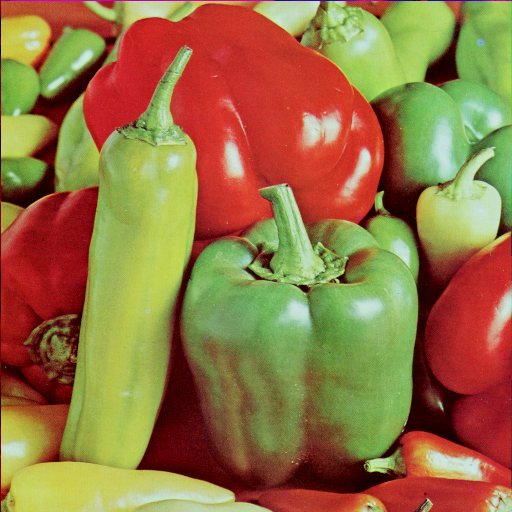

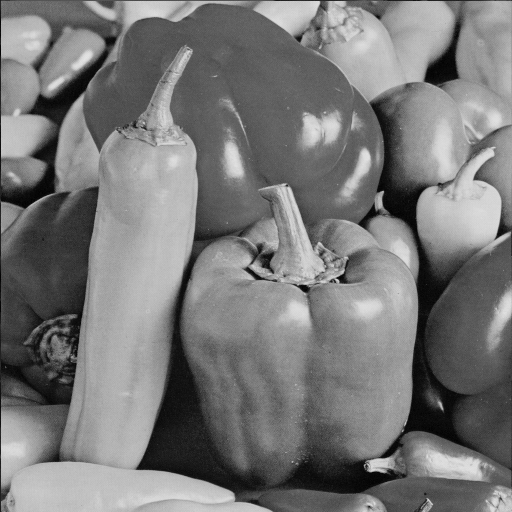

In [4]:
url = "http://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07"
img = skimage.io.imread(url)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # openCV uses BGR (blue, green, red) representation
cv2_imshow(img)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_img)

# 7.1 Amplitude segmentation

Amplitude segmentation is the simplest way to segment an image. It is useful (efficient) when amplitude (the intensity of the pixel) defines the scene regions precisely enough. To perform amplitude segmentation, we can use the first order histogram.

## 7.1.1 Manual determination of threshold
In this part of the exercise, we will determine the segmentation threshold based on the histogram. If there are several regions with the more-or-less uniform color within each of them, then we expect histogram to be bimodal or multimodal. The interpretation of the histogram depends on the histogram itself and/or knowledge of the image content (e.g. number of regions and similarity of their colors or intensities).

An example of such a histogram is given in the Fig. 7.1. In this histogram we see several groups, and we would choose a threshold value 130 for segmentation into two classes. An optimal choice of the threshold corresponds to
the minimum value between two (local) maxima. If the histogram is multimodal and we want to segment the image into $N$ classes then we have to determine $N-1$ such thresholds.

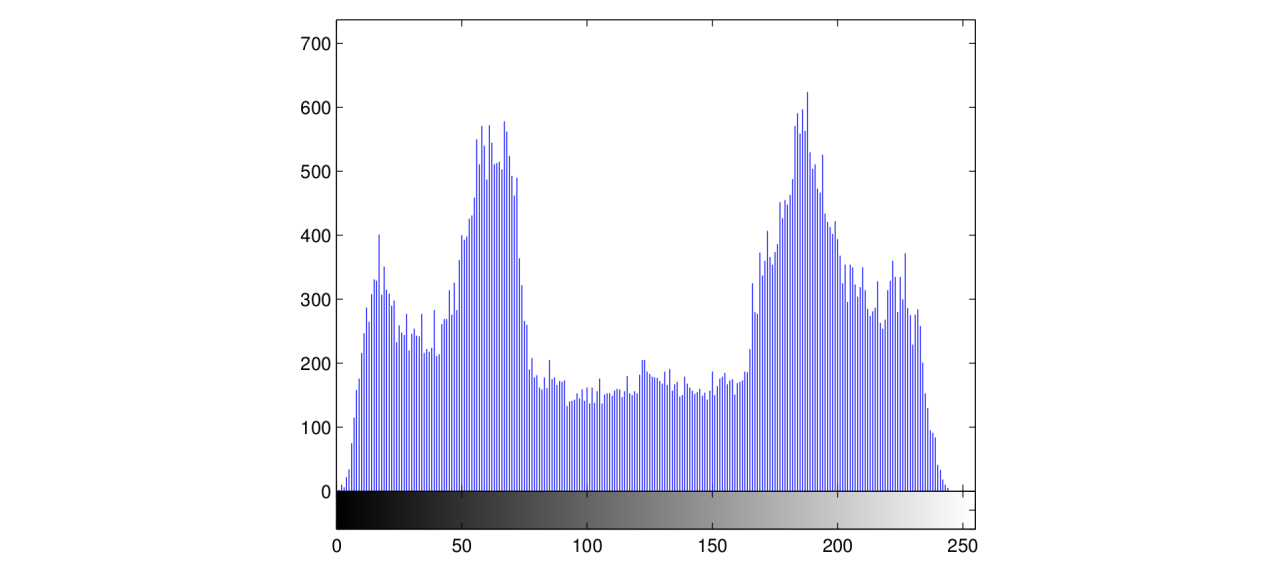

## <center>Figure 7.1: First-order histogram of an image. </center>



## Example

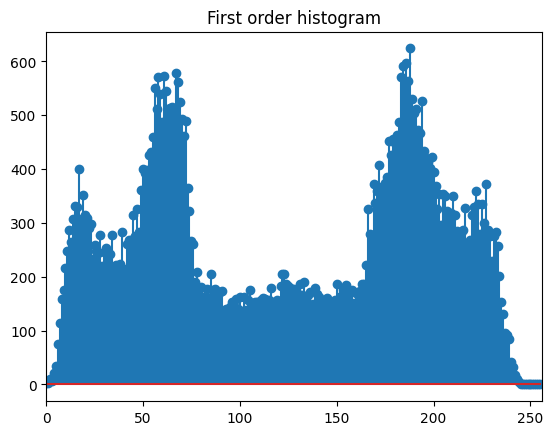

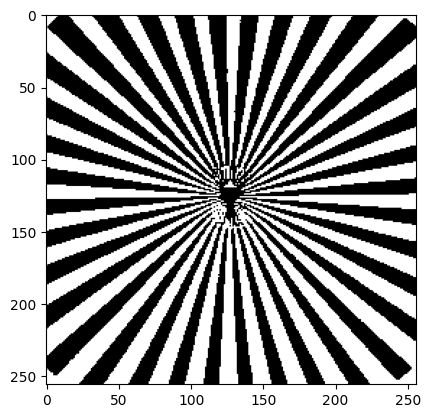

In [5]:
img = cv2.imread('/content/drive/My Drive/Images/testpat1.tif', cv2.IMREAD_GRAYSCALE)

hist, bin_edges = np.histogram(img.flatten(), bins = 256, range = (0, 256))     # calculate and show histogram
plt.figure()
plt.title("First order histogram")
plt.xlim((0, 256))
plt.stem(bin_edges[:-1], hist)
plt.show()

imgS1 = img > 130                                                               # if we interpret the histogram as bimodal, then we select 1 threshold
                                                                                # this results in a boolean array with 'true' representing '1' and 'false' representing '0'
plt.imshow(imgS1, cmap='gray')                                                  # meaning we got a binary image
plt.show()

### **7.1.2 Problems**



2. Read the image blood1.tif, showing blood cells. We want to segment the image so that cells are represented with an annulus (two concentric circles) with as little noise as possible. In the segmented image, blood cells will have a cavity in the middle. Display the histogram, determine an optimal threshold $t$, and display the segmented image.


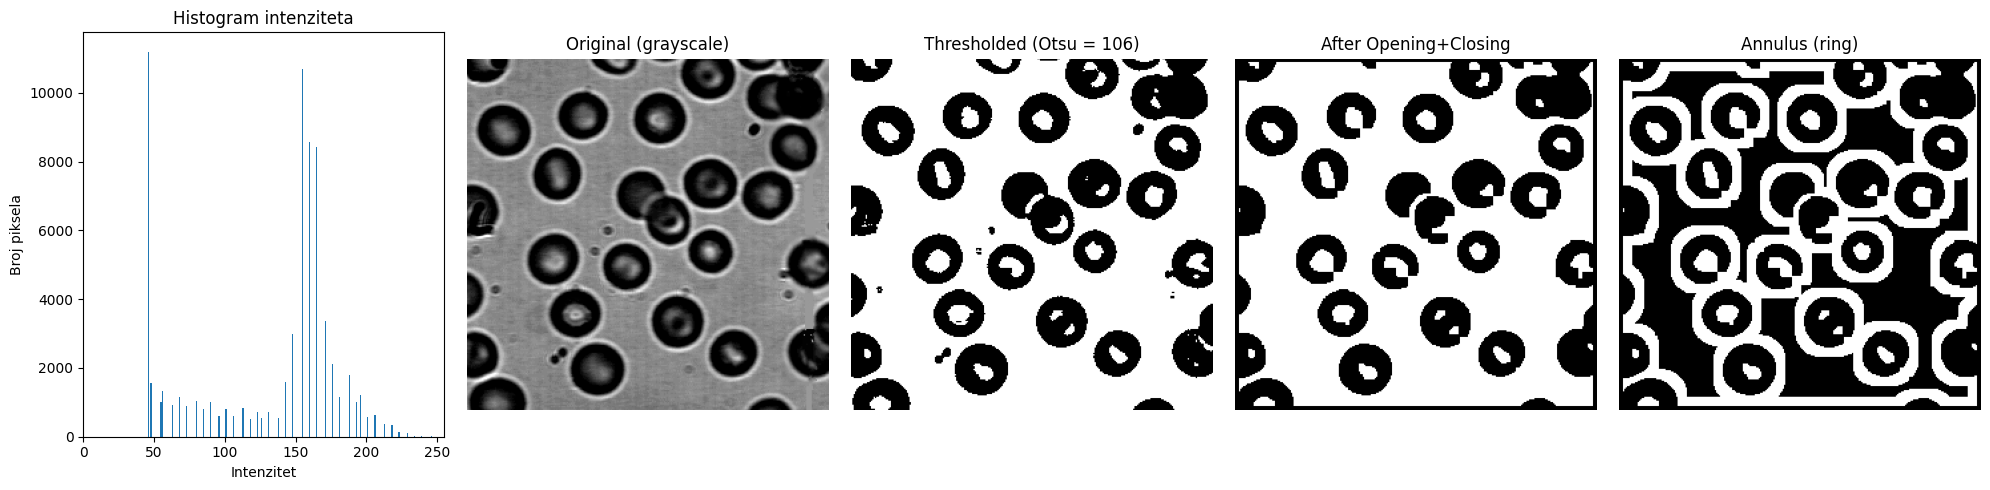

In [24]:
from scipy.ndimage import binary_opening, binary_closing, binary_erosion

img = cv2.imread('/content/drive/My Drive/Images/blood1.tif', cv2.IMREAD_GRAYSCALE)
hist, bin_edges = np.histogram(img.flatten(), bins=256, range=(0,256))
otsu_thresh, otsu_img = cv2.threshold(
    img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
mask = otsu_img.astype(bool)
mask_clean = binary_opening(mask, structure=np.ones((3,3)))
mask_clean = binary_closing(mask_clean, structure=np.ones((7,7)))
inner = binary_erosion(mask_clean, structure=np.ones((15,15)))
ring = mask_clean ^ inner  # XOR
plt.figure(figsize=(20,5))

titles = [
    'Histogram intenziteta',
    'Original (grayscale)',
    f'Thresholded (Otsu = {otsu_thresh:.0f})',
    'After Opening+Closing',
    'Annulus (ring)'
]
images = [
    (hist, bin_edges),
    img,
    mask,
    mask_clean,
    ring
]

plt.subplot(1, 5, 1)
plt.bar(bin_edges[:-1], hist, width=1)
plt.title(titles[0])
plt.xlim(0,255)
plt.xlabel('Intenzitet')
plt.ylabel('Broj piksela')

for i, (im, t) in enumerate(zip(images[1:], titles[1:]), start=2):
    plt.subplot(1, 5, i)
    plt.imshow(im, cmap='gray')
    plt.title(t)
    plt.axis('off')

plt.tight_layout()
plt.show()


3. For the same image display the results if you select a threshold $t+50$ or $t−50$ instead of threshold $t$ selected before. Describe what happened.


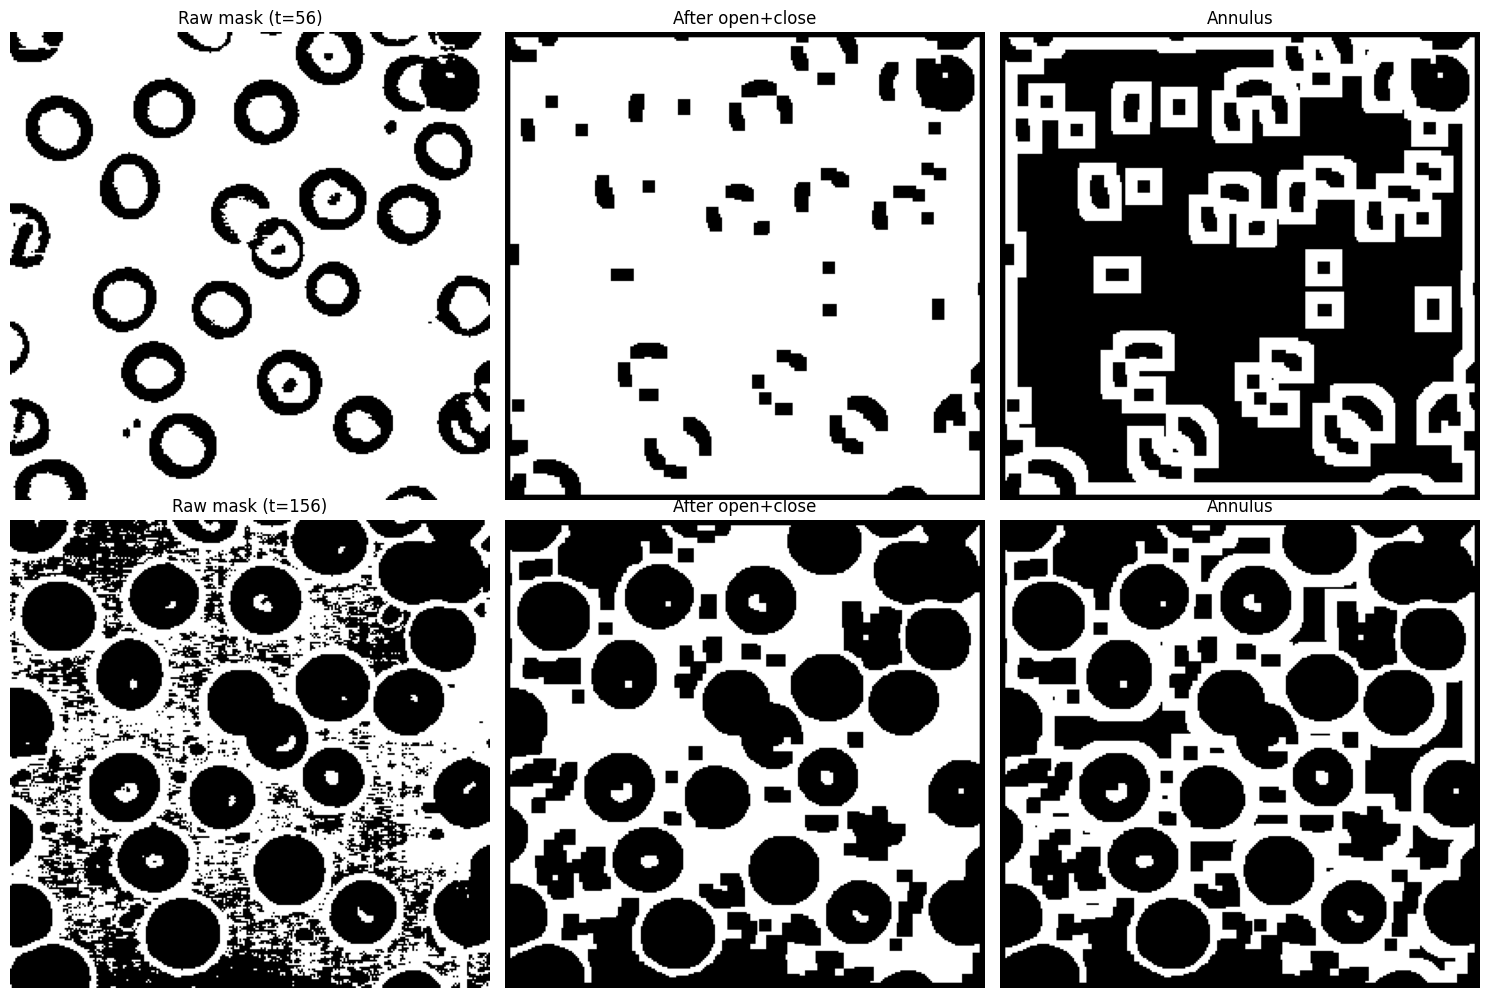

In [25]:
img = cv2.imread('/content/drive/My Drive/Images/blood1.tif', cv2.IMREAD_GRAYSCALE)
otsu_t, _ = cv2.threshold(
    img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

t_low  = max(0, int(otsu_t - 50))
t_high = min(255, int(otsu_t + 50))
thresholds = [t_low, t_high]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for row, t in enumerate(thresholds):
    mask       = img > t
    cleaned    = binary_opening(mask, structure=np.ones((3,3)))
    cleaned    = binary_closing(cleaned, structure=np.ones((7,7)))
    inner      = binary_erosion(cleaned, structure=np.ones((15,15)))
    annulus    = cleaned ^ inner

    axes[row,0].imshow(mask,    cmap='gray'); axes[row,0].set_title(f'Raw mask (t={t})');    axes[row,0].axis('off')
    axes[row,1].imshow(cleaned, cmap='gray'); axes[row,1].set_title('After open+close'); axes[row,1].axis('off')
    axes[row,2].imshow(annulus, cmap='gray'); axes[row,2].set_title('Annulus');            axes[row,2].axis('off')
    axes[row,0].set_ylabel('t−50' if row==0 else 't+50', size='large')

plt.tight_layout()
plt.show()


Using a threshold 50 levels below Otsu’s value floods the mask—background noise and cell interiors merge, so the ring structure vanishes. Raising the threshold 50 levels above Otsu captures only the brightest spots, breaking or completely losing most rings. Otsu’s automatic threshold strikes the optimal balance between these extremes.

# 7.2 Automatic determination of the threshold
In this part of the exercise, we will demonstrate the success of specific  algorithms in automatic determination of the threshold. `scikit-image` has [several thresholding functions](https://scikit-image.org/docs/dev/api/skimage.filters.html):
- `skimage.filters.threshold_isodata`
- `skimage.filters.threshold_li`
- `skimage.filters.threshold_mean`
- `skimage.filters.threshold_minimum`
- `skimage.filters.threshold_multiotsu`
- `skimage.filters.threshold_niblack`
- `skimage.filters.threshold_otsu`
- `skimage.filters.threshold_sauvola`
- `skimage.filters.threshold_triangle`
- `skimage.filters.threshold_yen`.

Thresholding algorithms implemented in scikit-image can be separated in two categories:

- Histogram-based. The histogram of the pixels’ intensity is used and certain assumptions are made on the properties of this histogram (e.g. bimodal).

- Local. To process a pixel, only the neighboring pixels are used. These algorithms often require more computation time but perform better in case of more complex images.

If you are not familiar with the details of the different algorithms and the underlying assumptions, it is often difficult to know which algorithm will give the best results. Therefore, Scikit-image includes the function `skimage.filters.try_all_threshold` to evaluate thresholding algorithms provided by the library. At a glance, you can select the best algorithm for you data.

\\
**Note:** `skimage.filters.threshold_multiotsu` is used to segment into more than just two regions.




## Example

50


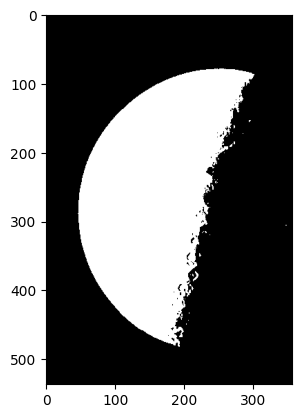

In [26]:
img = cv2.imread('/content/drive/My Drive/Images/moon.tif', cv2.IMREAD_GRAYSCALE)

#the minimum algorithm takes a histogram of the image and smooths it repeatedly until there are only two peaks in the histogram and finds a minimum value between the two maxima
thresh_min = threshold_minimum(img)                                             # finding the threshold
print(thresh_min)
binary_min = img > thresh_min                                                   # applying the threshold

plt.imshow(binary_min, cmap='gray')
plt.show()

## Example

[ 39 102 155 205]


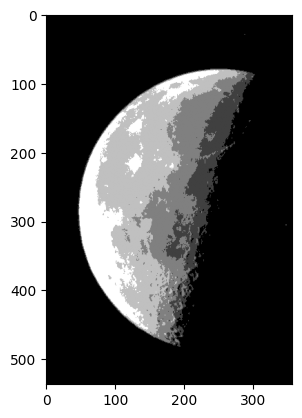

In [27]:
img = cv2.imread('/content/drive/My Drive/Images/moon.tif', cv2.IMREAD_GRAYSCALE)

#the multiotsu algorithm calculates several thresholds, determined by the number of desired classes
threshs_mo = threshold_multiotsu(img, classes=5)                                # finding the threshold
print(threshs_mo)
regions = np.digitize(img, bins=threshs_mo)                                     # applying the threshold

plt.imshow(regions, cmap='gray')
plt.show()

### **7.2.1 Problems**
1. Read the image blood1.tif. Try the segmentation using thresholds obtained using the following functions:
- `skimage.filters.threshold_mean`
- `skimage.filters.threshold_minimum`
- `skimage.filters.threshold_otsu`
- `skimage.filters.threshold_multiotsu` (3 and 4 classes).

Compare the threshold values obtained with the manual approach. How do the listed functions determine the threshold(s)?

threshold_mean   = 129.7943396226415
threshold_minimum= 109
threshold_otsu   = 106
threshold_multiotsu (3 classes) = [ 73 131]
threshold_multiotsu (4 classes) = [ 73 131 176]


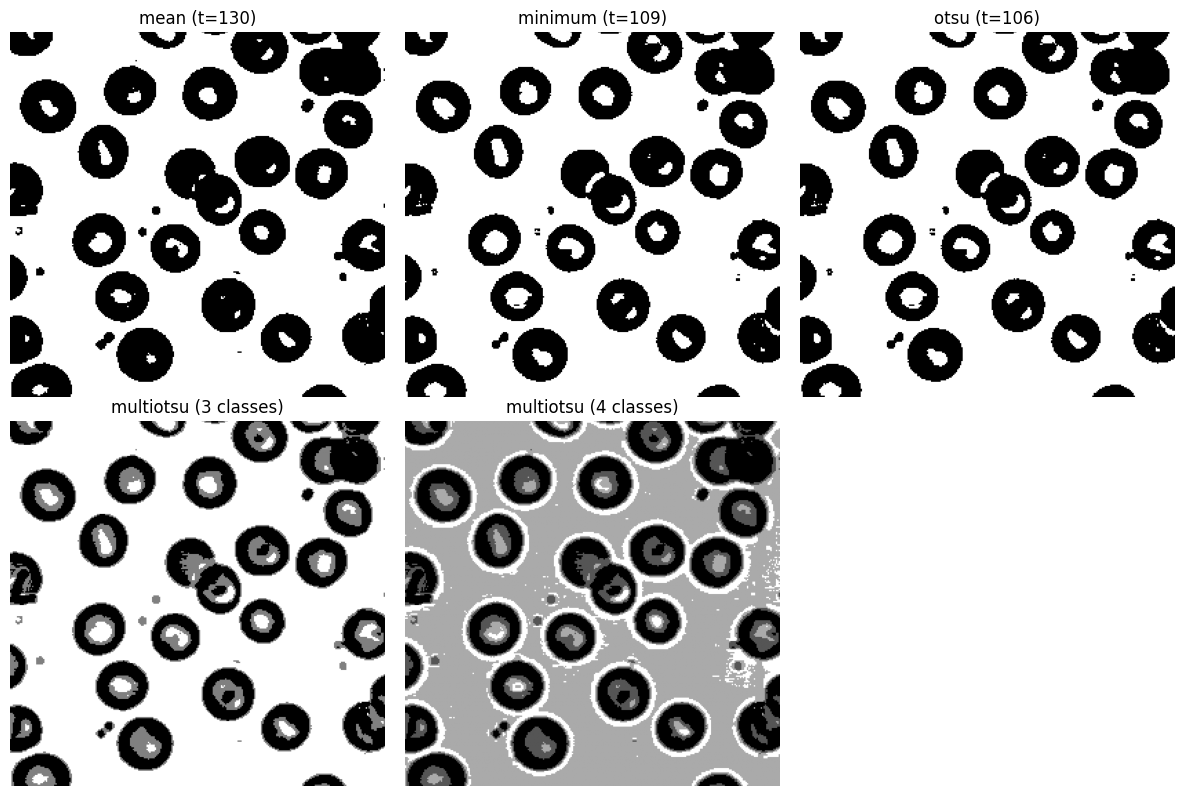

In [28]:
from skimage.filters import (
    threshold_mean,
    threshold_minimum,
    threshold_otsu,
    threshold_multiotsu
)

img = cv2.imread('/content/drive/My Drive/Images/blood1.tif', cv2.IMREAD_GRAYSCALE)

t_mean     = threshold_mean(img)
t_min      = threshold_minimum(img)
t_otsu     = threshold_otsu(img)
t_multi3   = threshold_multiotsu(img, classes=3)
t_multi4   = threshold_multiotsu(img, classes=4)

print(f"threshold_mean   = {t_mean}")
print(f"threshold_minimum= {t_min}")
print(f"threshold_otsu   = {t_otsu}")
print(f"threshold_multiotsu (3 classes) = {t_multi3}")
print(f"threshold_multiotsu (4 classes) = {t_multi4}")

bin_mean   = img > t_mean
bin_min    = img > t_min
bin_otsu   = img > t_otsu
regions3   = np.digitize(img, bins=t_multi3)
regions4   = np.digitize(img, bins=t_multi4)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

titles = [
    f"mean (t={t_mean:.0f})",
    f"minimum (t={t_min:.0f})",
    f"otsu (t={t_otsu:.0f})",
    "multiotsu (3 classes)",
    "multiotsu (4 classes)"
]
images = [bin_mean, bin_min, bin_otsu, regions3, regions4]

for ax, im, title in zip(axes, images, titles):
    ax.imshow(im, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

axes[-1].axis('off')

plt.tight_layout()
plt.show()


mean (t≈130) uses the global average, so it cuts too high—rims become thinner and some detail is lost.

minimum (t≈109) and Otsu (t≈106) both find the histogram valley between peaks, reproducing crisp rings very close to your manual choice.

multi-Otsu (3 and 4 classes) extends Otsu to two or three cut-points, splitting background, cell walls, and interiors into separate grey levels—but may over-segment when too many classes are used.

# 7.3. Local

If the image background is relatively uniform, then you can use a global threshold value as presented above. However, if there is large variation in the background intensity, adaptive thresholding (a.k.a. local or dynamic thresholding) may produce better results. Note that local is much slower than global thresholding.

Here, we binarize an image using the [skimage.filters.threshold_local](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_local) function, which calculates thresholds in regions with a characteristic size block_size surrounding each pixel (i.e. local neighborhoods). Each threshold value is the weighted mean of the local neighborhood minus an offset value.

## Example

Text(0.5, 1.0, 'Local')

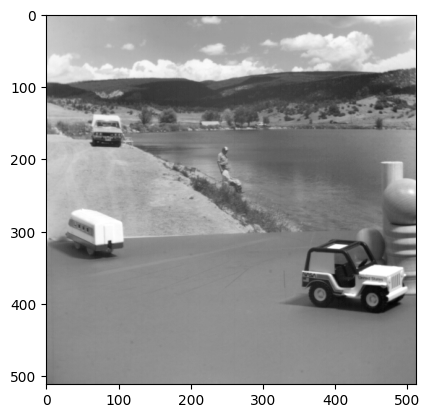

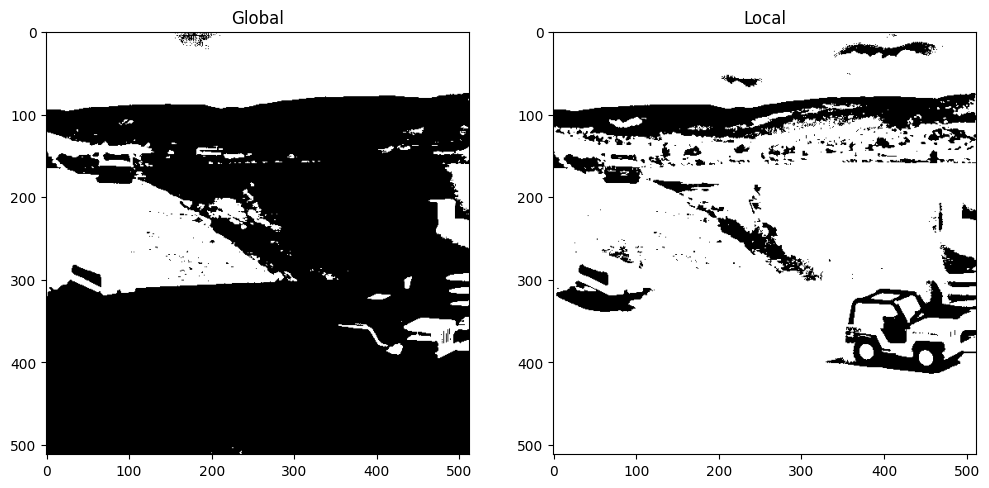

In [29]:
image = cv2.imread('/content/drive/My Drive/Images/slika4.tiff', cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray')

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 101
local_thresh = threshold_local(image, block_size, offset=10)
binary_local = image > local_thresh

fig, axes = plt.subplots(ncols=2, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(binary_global, cmap='gray')
ax[0].set_title('Global')

ax[1].imshow(binary_local, cmap='gray')
ax[1].set_title('Local')

### **7.3.1 Problems**
1. Try using local thresholding on the image 'moon.tif'. What do you notice?

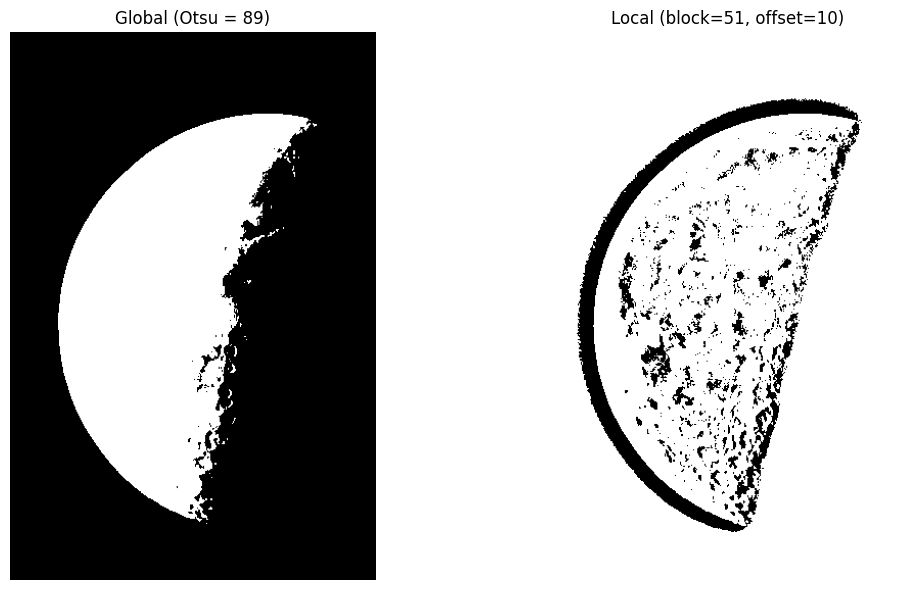

In [31]:
image = cv2.imread('/content/drive/My Drive/Images/moon.tif', cv2.IMREAD_GRAYSCALE)

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 51          # veličina prozora (možeš eksperimentirati)
offset = 10              # pomak za lokalni prag
local_thresh = threshold_local(image, block_size, offset=offset)
binary_local  = image > local_thresh

# 4. Prikaži rezultate
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(binary_global, cmap='gray')
axes[0].set_title(f'Global (Otsu = {global_thresh:.0f})')
axes[0].axis('off')

axes[1].imshow(binary_local, cmap='gray')
axes[1].set_title(f'Local (block={block_size}, offset={offset})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Global thresholding yields a clean, smooth half-moon silhouette but misses finer surface details, whereas local thresholding brings out crater textures and rim variations at the cost of heavy speckle noise and jagged edges.

# 7.4 Extraction of edges
We want to get a binary image (same dimensions as the input image) that contains only the detected edges from the input image. First step is edge detection, for which we can use first or second order derivative estimators.
Methods based on the first order derivative calculate the derivative estimation for each pixel. Amplitude segmentation is then applied to this image.
Methods based on the second order derivative detect zero-crossing of the intensity values. In this case, the threshold corresponds to the steepness of the edge.

## Example:

0.3531181473529842 0.0
255.0 0.0


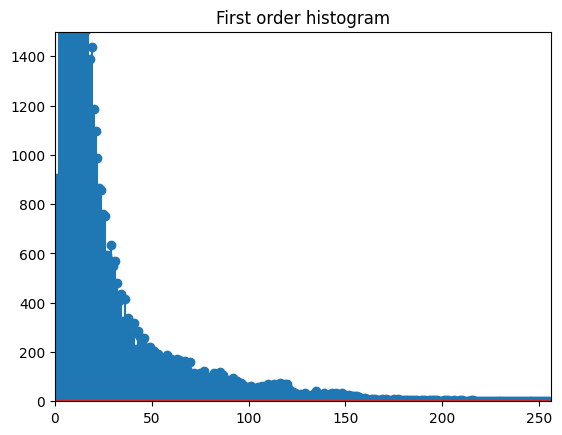

44.326171875


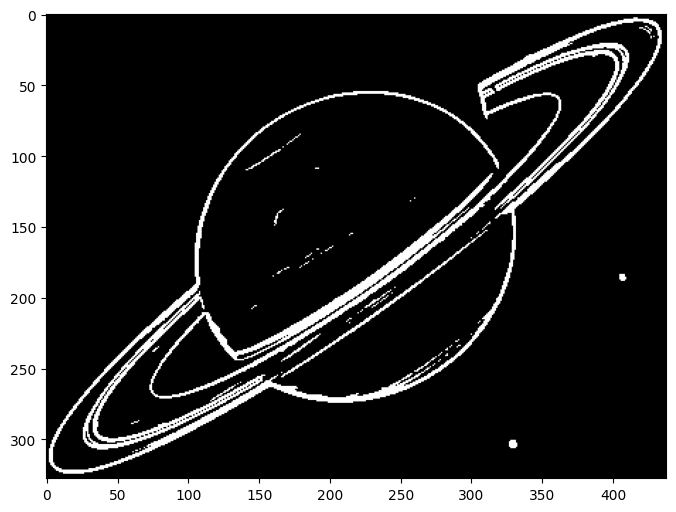

In [32]:
saturn = cv2.imread('/content/drive/My Drive/Images/saturn.tif', cv2.IMREAD_GRAYSCALE)# read the grayscale image

grad = sobel(saturn)                                                            # apply the Sobel operator

print(np.max(grad), np.min(grad))
grad = grad * 255 / np.max(grad)                                                # normalize
print(np.max(grad), np.min(grad))

hist, bin_edges = np.histogram(grad.flatten(), bins = 256, range = (0, 256))
plt.figure()
plt.title("First order histogram")
plt.xlim((0, 256))
plt.ylim((0, 1500))
plt.stem(bin_edges[:-1], hist)
plt.show()

thresh = threshold_otsu(grad)
print(thresh)
grad = grad > thresh                                                            # segment to make a binary image

plt.figure(figsize=(8,8))
plt.imshow(grad, cmap='gray')                                                   # visualizing the edges

### **7.4.1 Problems**
1. Read the image 4.2.07.tiff from the USC-SIPI database. Extract the edges using sobel operator and different thresholding methods. Which method gives the best edge detection?


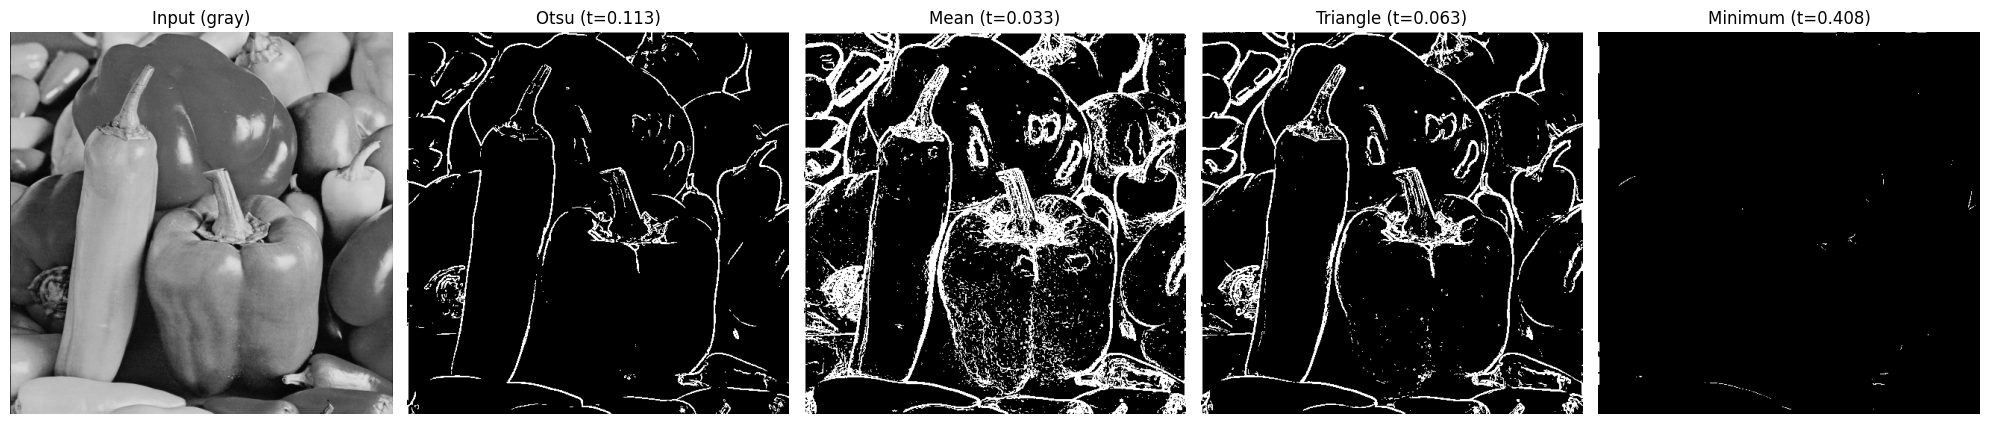

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from skimage.filters import (
    sobel,
    threshold_otsu,
    threshold_mean,
    threshold_triangle,
    threshold_minimum
)

url = "http://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07"
img_rgb = skimage.io.imread(url)                            # RGB float [0,1] or uint8 [0,255]
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)           # to BGR
gray_u8 = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)          # single‐channel uint8

img = gray_u8.astype(np.float64) / 255.0

grad = sobel(img)

t_otsu     = threshold_otsu(grad)
t_mean     = threshold_mean(grad)
t_triangle = threshold_triangle(grad)
t_minimum  = threshold_minimum(grad)

edges = {
    f"Otsu (t={t_otsu:.3f})"     : (grad > t_otsu).astype(float),
    f"Mean (t={t_mean:.3f})"     : (grad > t_mean).astype(float),
    f"Triangle (t={t_triangle:.3f})": (grad > t_triangle).astype(float),
    f"Minimum (t={t_minimum:.3f})" : (grad > t_minimum).astype(float)
}

fig, axes = plt.subplots(1, 5, figsize=(20, 6))
titles = ["Input (gray)"] + list(edges.keys())
images = [img] + list(edges.values())

for ax, im, title in zip(axes, images, titles):
    ax.imshow(im, cmap='gray', vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


Otsu’s method produces the cleanest, most continuous edge outlines with minimal noise. The mean threshold is too low (overly noisy), the triangle threshold is intermediate but still captures a lot of speckle, and the minimum threshold is too high, retaining only the very strongest edges.

2. Extract the edges of the image 4.2.07.tiff, using the **a) Sobel, b) DoG - [skimage.filters.difference_of_gaussians](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.difference_of_gaussians), and c) Canny operator - [skimage.feature.canny](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.canny), with the thresholding method selected in the previous task. Which operator works the best?

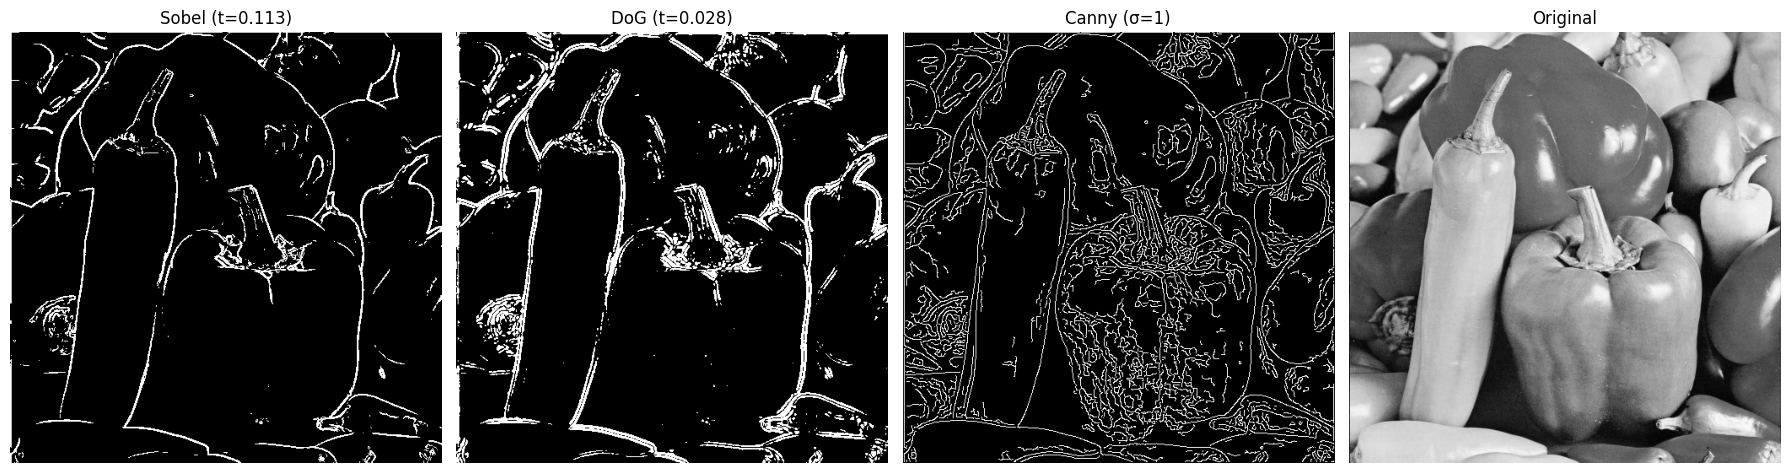

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from skimage.filters import (
    sobel,
    difference_of_gaussians,
    threshold_otsu
)
from skimage.feature import canny

url     = "http://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07"
img_rgb = skimage.io.imread(url)
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
gray_u8 = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img     = gray_u8.astype(np.float64) / 255.0

grad_sobel = sobel(img)
t_sobel    = threshold_otsu(grad_sobel)
edges_sobel = grad_sobel > t_sobel

dog        = difference_of_gaussians(img, low_sigma=1, high_sigma=2)
dog_abs    = np.abs(dog)
t_dog      = threshold_otsu(dog_abs)
edges_dog  = dog_abs > t_dog

edges_canny = canny(
    img,
    sigma=1.0,
    low_threshold=0.5 * t_sobel,
    high_threshold=t_sobel
)

fig, axes = plt.subplots(1, 4, figsize=(18, 6))
axes[0].imshow(edges_sobel, cmap='gray')
axes[0].set_title(f"Sobel (t={t_sobel:.3f})")

axes[1].imshow(edges_dog, cmap='gray')
axes[1].set_title(f"DoG (t={t_dog:.3f})")

axes[2].imshow(edges_canny, cmap='gray')
axes[2].set_title("Canny (σ=1)")

axes[3].imshow(img, cmap='gray')
axes[3].set_title("Original")

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


Sobel produces fairly thick, continuous edges but with some noise, DoG sharpens gradient boundaries more strongly yet still shows speckle, Canny gives the thinnest, most complete outlines with minimal false positives, making it the best overall.

3. Add the noise to the original image and repeat the edge detection with
the 3 operators. How does the noise affect the edge detection for these cases?

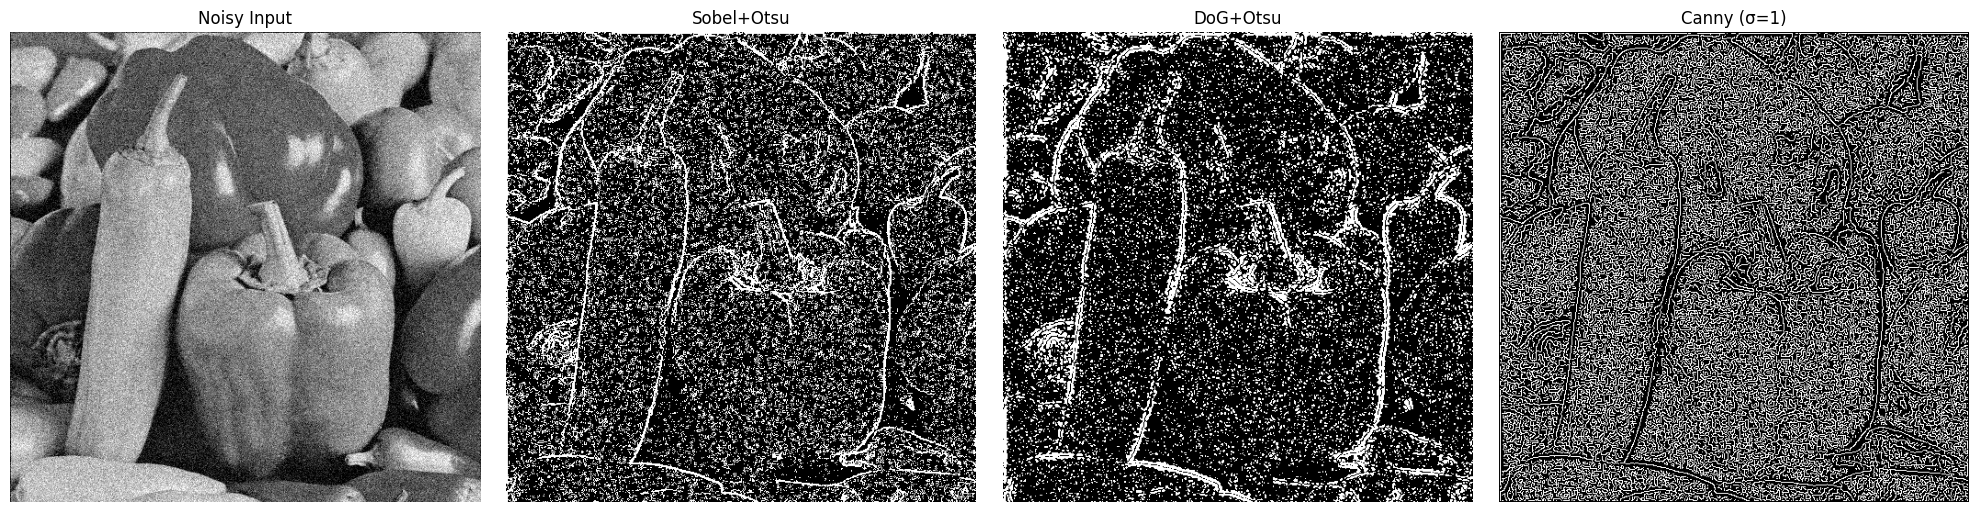

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from skimage.filters import sobel, difference_of_gaussians, threshold_otsu
from skimage.feature import canny
from skimage.util import random_noise

url     = "http://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07"
rgb     = skimage.io.imread(url)
bgr     = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
gray_u8 = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
img     = gray_u8.astype(float) / 255.0

noisy = random_noise(img, mode='gaussian', var=0.01)

grad_s = sobel(noisy)
t_s    = threshold_otsu(grad_s)
edges_sobel = grad_s > t_s

dog    = difference_of_gaussians(noisy, 1, 2)
t_d    = threshold_otsu(np.abs(dog))
edges_dog = np.abs(dog) > t_d

edges_canny = canny(noisy, sigma=1.0, low_threshold=0.5*t_s, high_threshold=t_s)

fig, ax = plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(noisy,      cmap='gray'); ax[0].set_title("Noisy Input");   ax[0].axis('off')
ax[1].imshow(edges_sobel,cmap='gray'); ax[1].set_title("Sobel+Otsu");  ax[1].axis('off')
ax[2].imshow(edges_dog,  cmap='gray'); ax[2].set_title("DoG+Otsu");    ax[2].axis('off')
ax[3].imshow(edges_canny,cmap='gray'); ax[3].set_title("Canny (σ=1)"); ax[3].axis('off')
plt.tight_layout()
plt.show()

Adding noise floods the gradient maps with speckle, so Sobel+Otsu and DoG+Otsu pick up countless false edges. Canny, thanks to its Gaussian smoothing, yields more coherent outlines but still shows heavy noise artifacts. Overall, noise dramatically degrades all three methods, with Canny slightly more robust.

# 7.5 Texture segmentation
We will segment the textures based on selected features. First, for each pixel in the image, we will calculate the selected feature on the defined neighboorhod of the pixel. Texture features are calculated from 2nd order histograms. The image containing the feature values is the image we will segment.

The 2nd order histogram can be calculated using [skimage.feature.graycomatrix](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycomatrix). Its features can be calculated using [skimage.feature.graycoprops](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycoprops).

# Example

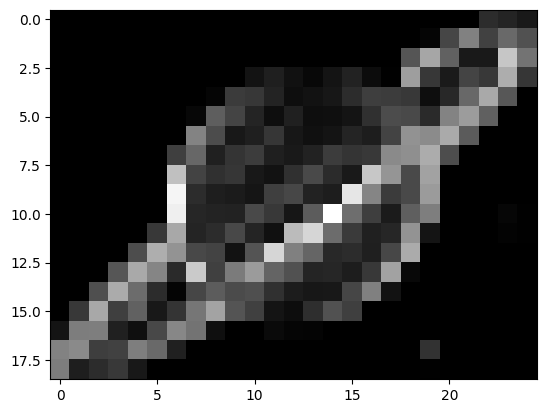

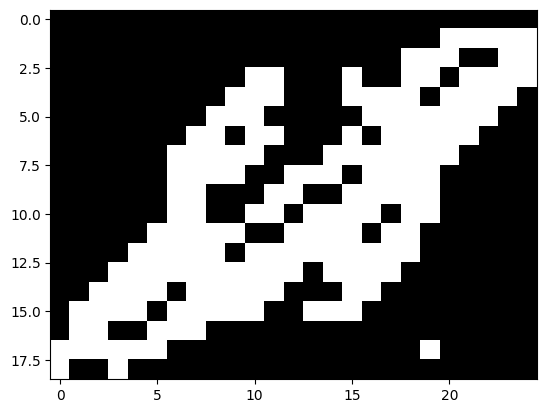

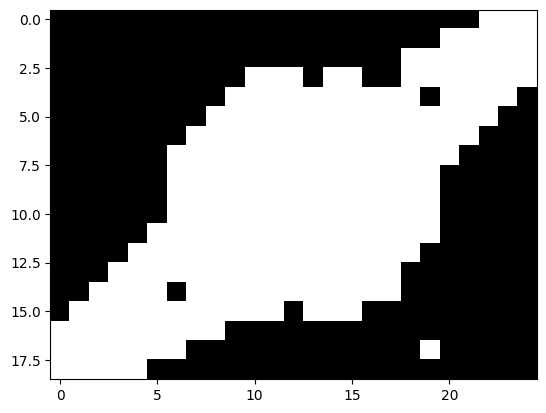

In [43]:
img = cv2.imread('/content/drive/My Drive/Images/saturn.tif', cv2.IMREAD_GRAYSCALE)

patch_size=17
v_shifts = img.shape[0] // patch_size
h_shifts = img.shape[1] // patch_size
feat_img = np.empty(shape=(v_shifts, h_shifts), dtype=float)                    #empty result matrix, will be filled in the 'for' loops

for i in range(v_shifts):
    for j in range(h_shifts):
        patch = img[i*patch_size:i*patch_size + patch_size, j*patch_size:j*patch_size + patch_size]

        hist_2nd = graycomatrix(patch, distances=[5], angles=[0], levels=256,
                                symmetric=True, normed=True)                    # horizontal offset of 5, defined by distance and angle

        #print(patch.shape, hist_2nd.shape, "- the dimensions are: levels x levels x number of distances x number of angles.")

        dissi = graycoprops(hist_2nd, 'dissimilarity')[0,0]
        feat_img[i,j] = dissi                                                   # filling the result matrix

plt.imshow(feat_img, cmap='gray')
plt.show()

feat_img_segm1 = feat_img > threshold_niblack(feat_img)                         # segmentation
plt.imshow(feat_img_segm1, cmap='gray')
plt.show()
feat_img_segm2 = feat_img > 3
plt.imshow(feat_img_segm2, cmap='gray')


### **7.5.1 Problems**

1. Read the image texture.png. Display the image. How many textures are there in the image? Describe them.


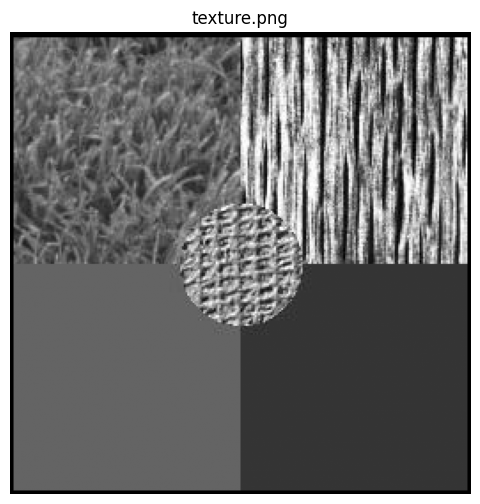

In [44]:
img = cv2.imread('/content/drive/My Drive/Images/texture.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("texture.png")
plt.show()

There are five distinct textures in texture.png:\
    Top-left: a fine, irregular “grass”\
    Top-right: strong vertical “wood‐grain” stripes\
    Bottom-left: a smooth uniform mid-gray patch\
    Bottom-right: a uniform dark-gray area.\
    Center circle: a woven, basket-weave pattern.

2. Select several features and calculate them on the blocks (patches) of size 12 × 12. Display the calculated features and estimate which ones can be used to segment given structure. For the selected images (features) choose a good thresholding method and comment on the results.

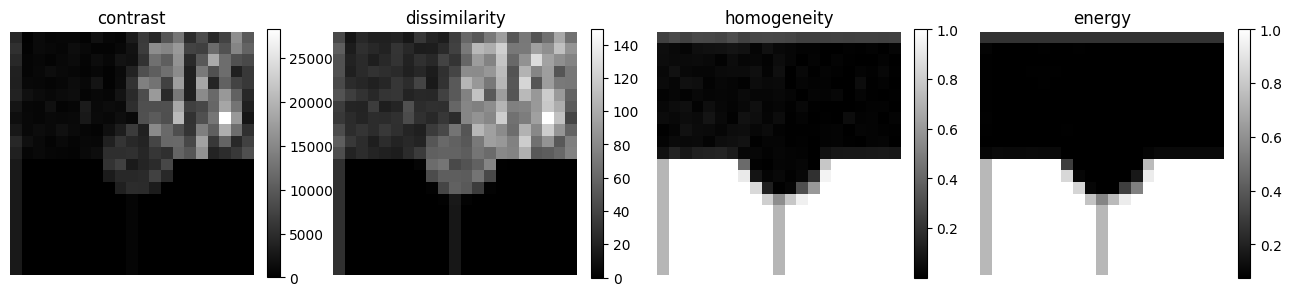

In [45]:
from skimage.feature import graycomatrix, graycoprops

img = cv2.imread('/content/drive/My Drive/Images/texture.png', cv2.IMREAD_GRAYSCALE)

patch = 12
rows, cols = img.shape[0]//patch, img.shape[1]//patch
feat_maps = {
    'contrast':     np.zeros((rows, cols)),
    'dissimilarity':np.zeros((rows, cols)),
    'homogeneity':  np.zeros((rows, cols)),
    'energy':       np.zeros((rows, cols))
}

for i in range(rows):
    for j in range(cols):
        block = img[i*patch:(i+1)*patch, j*patch:(j+1)*patch]
        glcm = graycomatrix(block, distances=[5], angles=[0], levels=256,
                            symmetric=True, normed=True)
        for name in feat_maps:
            feat_maps[name][i,j] = graycoprops(glcm, name)[0,0]

fig, axes = plt.subplots(1, 4, figsize=(16,4))
for ax, (name, fmap) in zip(axes, feat_maps.items()):
    im = ax.imshow(fmap, cmap='gray')
    ax.set_title(name)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046)
plt.show()

Contrast and dissimilarity both light up the grass, wood‐grain and weave regions strongly while remaining dark over the uniform patches, giving clear separation of textured vs. flat areas. Homogeneity and energy behave oppositely (high only on the smooth quadrants), so they’re less useful for isolating multiple textures. Among these, dissimilarity offers the best dynamic range to threshold—applying Otsu to the dissimilarity map cleanly segments all textured regions from the flat ones.

# 8.1 Image registration
Image registration is a process consisting of an image transformation, a similarity measure (for evaluation
of the quality of the registration) and of an optimization function (for maximizing the similarity measure).

The combination of those three elements into a registration process is given with a Fig. 8.1.

The basic idea is this: We are registering the input image $I_S$ to the reference image $I_R$, by iteratively applying (and adapting)
the necessary transform $T$ to the image $I_S$.
Similarity measure is some measure of energy or error, and is denoted as E in this figure. Optimization
algorithm is illustrated with the feedback.

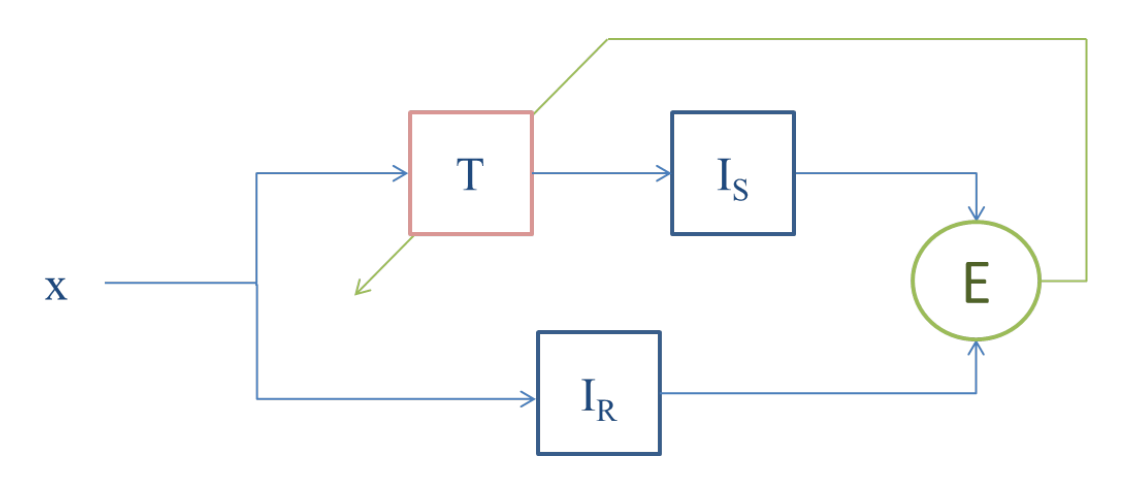

## <center>Figure 8.1: Image acquisition system. </center>

Geometrical transform is performed on the pixels’ coordinates, and not on their intensities, therefore we can
write: $$ I_T(x) = I_S(T(x)) $$
where x denotes the coordinates (x, y) (for the 2D images).

For the sake of simplicity, we won’t be performing the optimization, but we will solve the problem by examining the complete image space with the similarity measure, and detecting its maximum.

$$ r = \frac{\sum_{m=1}^{M}{\sum_{n=1}^{N}{(X_{mn}-\bar{X})(Y_{mn}-\bar{Y})}}}
{\sqrt{\sum_{m=1}^{M}{\sum_{n=1}^{N}{(X_{mn}-\bar{X})^2}}}
 \sqrt{\sum_{m=1}^{M}{\sum_{n=1}^{N}{(Y_{mn}-\bar{Y})^2}}}} $$

We are going to use cross-correlation $r$ as a similarity measure: where
$M$ and $N$ denote the dimensions of the overlapping area of images $X$ and $Y$, and $\bar{X}$ and $\bar{Y}$ denote mean values of $X$ and $Y$ calculated as:

$$ \bar{X} = \frac{1}{MN}\sum_{m=1}^{M}{\sum_{n=1}^{N}{X_{mn}}} $$

$$ \bar{Y} = \frac{1}{MN}\sum_{m=1}^{M}{\sum_{n=1}^{N}{Y_{mn}}} $$

In this exercise we will use registration to:

- find an object in an image
- track the object in a series of images
- determine the object’s orientation.

### **8.1.1 Problems**

1. Calculate the cross-correlation matrix $R$ for the images auto1.tiff and slika1.tiff. *Hint: Use the function [skimage.feature.match_template()](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.match_template)*

Best match at position (row, col) = (293, 40), R = 0.660


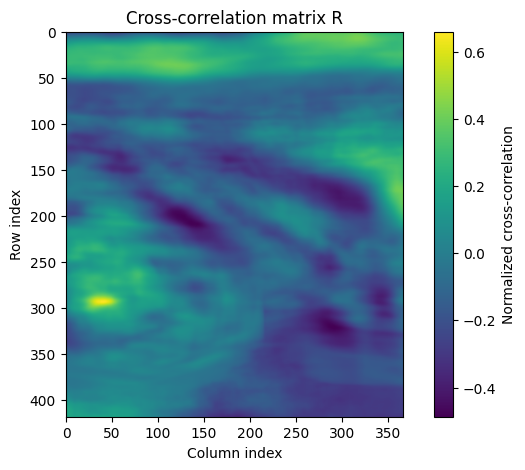

In [46]:
import matplotlib.pyplot as plt
from skimage import io, feature, color

src = io.imread('/content/drive/My Drive/Images/slika1.tiff', as_gray=True)
template = io.imread('/content/drive/My Drive/Images/auto1.tiff', as_gray=True)

R = feature.match_template(src, template)

ij = R.argmax()
x, y = divmod(ij, R.shape[1])
print(f"Best match at position (row, col) = ({x}, {y}), R = {R[x, y]:.3f}")

plt.figure(figsize=(8, 5))
plt.imshow(R, cmap='viridis')
plt.colorbar(label='Normalized cross-correlation')
plt.title('Cross-correlation matrix R')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.show()


2. What are the coordinates $(m_i, m_j)$ of the maximum value of the cross-correlation matrix $R$?

In [47]:
# Write-in your solution
max_idx = np.argmax(R)
m_i, m_j = np.unravel_index(max_idx, R.shape)

print(f"Maximum R at (row, col) = ({m_i}, {m_j}), value = {R[m_i, m_j]:.3f}")

Maximum R at (row, col) = (293, 40), value = 0.660


Maximum R at (row, col) = (293, 40), value = 0.660

3. Display the image slika1.tiff and plot the rectangle with the dimensions of the image auto1.tiff on the location of the maximum $(m_i, m_j)$.

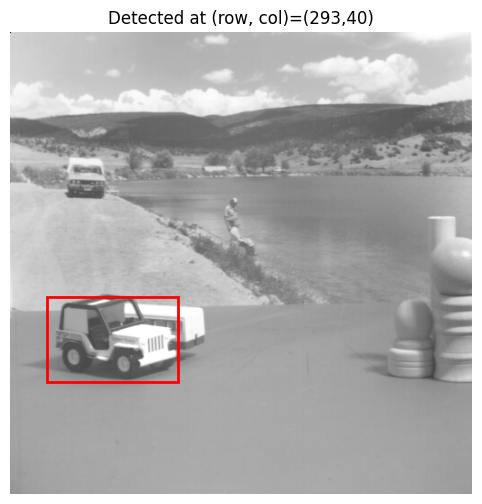

In [48]:
from skimage.feature import match_template
from matplotlib.patches import Rectangle

ref_path      = '/content/drive/My Drive/Images/slika1.tiff'
templ_path    = '/content/drive/My Drive/Images/auto1.tiff'
I_R           = cv2.imread(ref_path,   cv2.IMREAD_GRAYSCALE)
I_S           = cv2.imread(templ_path, cv2.IMREAD_GRAYSCALE)

R = match_template(I_R, I_S)

max_idx = np.argmax(R)
m_i, m_j = np.unravel_index(max_idx, R.shape)

h, w = I_S.shape  # height, width of the template

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(I_R, cmap='gray')
# Rectangle takes (x,y) = (col,row)
rect = Rectangle((m_j, m_i), w, h,
                 edgecolor='r', facecolor='none', linewidth=2)
ax.add_patch(rect)

ax.set_title(f'Detected at (row, col)=({m_i},{m_j})')
ax.axis('off')
plt.show()

4. Calculate the cross-correlation matrix $R$ for the images auto1.tiff and

- slika2.tiff

- slika3.tiff

- slika4.tiff

Display the detections and interpret the results.

slika2.tiff → best match at (row,col)=(296,77), R=0.856
slika3.tiff → best match at (row,col)=(304,211), R=1.000
slika4.tiff → best match at (row,col)=(317,356), R=0.858


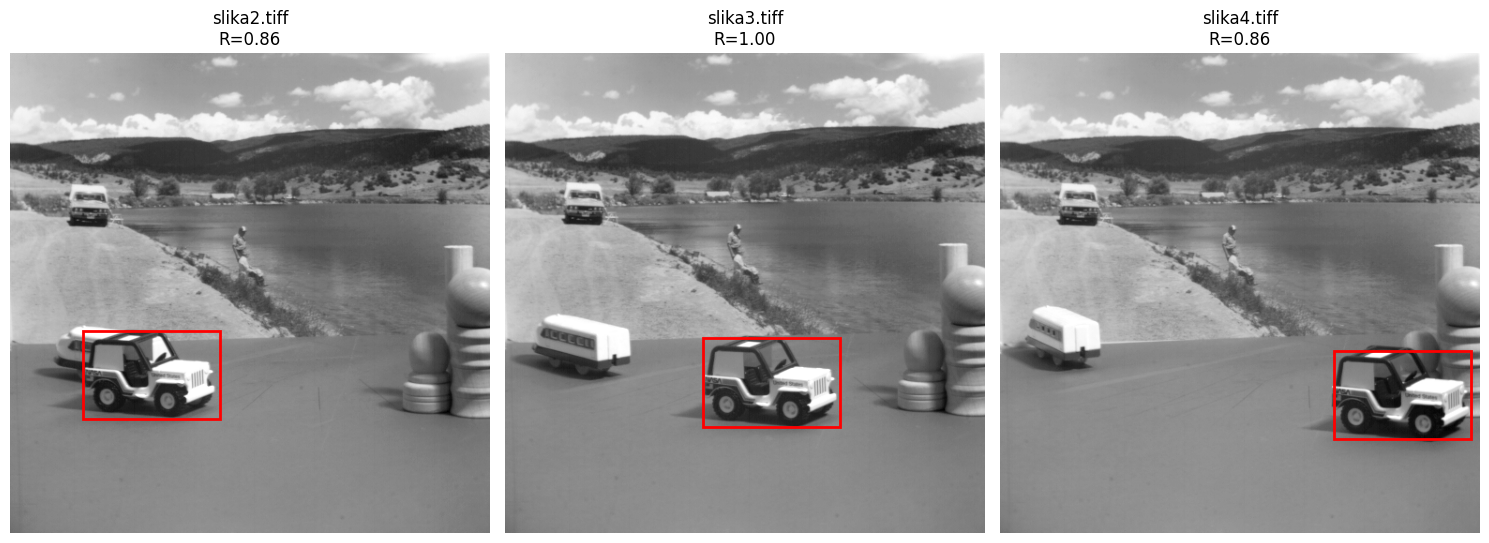

In [49]:
template_path = '/content/drive/My Drive/Images/auto1.tiff'
search_paths  = [
    '/content/drive/My Drive/Images/slika2.tiff',
    '/content/drive/My Drive/Images/slika3.tiff',
    '/content/drive/My Drive/Images/slika4.tiff',
]

# load template
templ = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
h, w = templ.shape

# prepare figure
fig, axes = plt.subplots(1, len(search_paths), figsize=(5*len(search_paths), 6))

for ax, path in zip(axes, search_paths):
    # load search image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # compute normalized cross-correlation
    R = match_template(img, templ)

    # find peak
    ij = np.unravel_index(np.argmax(R), R.shape)
    mi, mj = ij
    peak = R[mi, mj]
    print(f"{path.split('/')[-1]} → best match at (row,col)=({mi},{mj}), R={peak:.3f}")

    # show image with detection rectangle
    ax.imshow(img, cmap='gray')
    rect = Rectangle((mj, mi), w, h, edgecolor='r', facecolor='none', linewidth=2)
    ax.add_patch(rect)
    ax.set_title(f"{path.split('/')[-1]}\nR={peak:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Using normalized cross-correlation with the toy‐car template, the algorithm consistently located the car in all three scenes. In slika3.tiff, where the car’s scale, orientation, and lighting match the template exactly, the correlation peaked at R = 1.00, indicating a perfect match. In slika2.tiff and slika4.tiff, slight differences in viewpoint and illumination lowered the peak correlation to about R ≈ 0.86, yet these values remain sufficiently high to correctly detect and localize the car. Overall, this demonstrates that normalized cross‐correlation is robust to moderate variations in appearance and can reliably find the object across different images.

5. Write a function that calculates the cross-correlation of two images where one of the images is only rotated
for a single angle $\alpha$. The inputs should be $S_1$,
$S_2$, and $\alpha$; the output should be the cross-correlation value for the given angle.

In [51]:
def cross_correlation_rotated(S1: np.ndarray, S2: np.ndarray, alpha: float) -> float:
    S1f = S1.astype(np.float64)
    S2f = S2.astype(np.float64)

    h, w = S2f.shape
    center = (w/2, h/2)
    M = cv2.getRotationMatrix2D(center, alpha, 1.0)
    S2r = cv2.warpAffine(S2f, M, (w, h), flags=cv2.INTER_LINEAR)

    X = S1f.ravel()
    Y = S2r.ravel()
    X̄ = X.mean()
    Ȳ = Y.mean()

    num = np.sum((X - X̄) * (Y - Ȳ))
    den = np.sqrt(np.sum((X - X̄)**2) * np.sum((Y - Ȳ)**2))
    return num / den

6. Calculate the cross-correlation values for the images auto1.tiff and auto2.tiff for all of the angles in the
$\alpha = range(0, 360, 1)$. Plot the curve that shows the cross-correlation values for all of these angles. Which
$\alpha$ corresponds to the maximal cross-correlation? Why?

Max correlation = 0.2703 at angle α = 269°


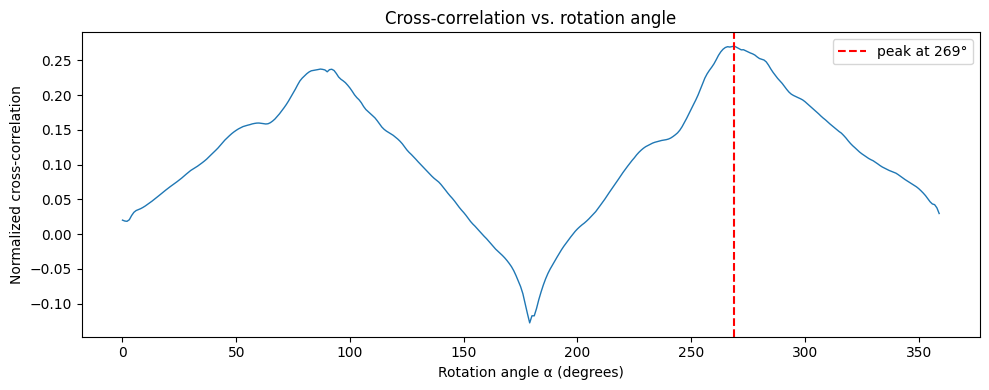

In [52]:
auto1 = cv2.imread('/content/drive/My Drive/Images/auto1.tiff', cv2.IMREAD_GRAYSCALE)
auto2 = cv2.imread('/content/drive/My Drive/Images/auto2.tiff', cv2.IMREAD_GRAYSCALE)

angles = np.arange(0, 360)
corrs  = [cross_correlation_rotated(auto1, auto2, a) for a in angles]

best_idx   = np.argmax(corrs)
best_angle = angles[best_idx]
best_val   = corrs[best_idx]

print(f"Max correlation = {best_val:.4f} at angle α = {best_angle}°")

plt.figure(figsize=(10,4))
plt.plot(angles, corrs, '-', lw=1)
plt.axvline(best_angle, color='r', linestyle='--',
            label=f'peak at {best_angle}°')
plt.title('Cross-correlation vs. rotation angle')
plt.xlabel('Rotation angle α (degrees)')
plt.ylabel('Normalized cross-correlation')
plt.legend()
plt.tight_layout()
plt.show()

The cross‐correlation curve reaches its global maximum at α = 269°, which is precisely the rotation that brings auto2.tiff into best alignment with auto1.tiff. The secondary peak at roughly α ≈ 89° is simply the 180°‐offset counterpart due to the inherent symmetry of the correlation measure. This demonstrates that normalized cross‐correlation can accurately recover the relative rotation between two images.

## 8.2 Optical flow

Optical flow is an independent estimate of motion at each pixel. This can be expressed with the following formula:

$$ OF(\{u_i\}) = \sum_i{[I_1(x_i + u_i) - I_0(x_i)]^2}$$

for some motion $\{u_i\}$ consisting of motion vectors $u_i$ defined for each pixel.

As one can see, the number of variables is larger than the number of measurements and therefore the problem in question is underconstrained.

### **8.2.1 Problems**

1. Write a function that calculates the optical flow between a grayscale image $S$ and the same image $S$ shifted by vector $D = (dx, dy)$ (Pad and crop the image as necessary). *Hint: Use the function [skimage.registration.optical_flow_tvl1()](https://scikit-image.org/docs/dev/api/skimage.registration.html?highlight=skimage%20registration#skimage.registration.optical_flow_tvl1)*

In [54]:
from skimage.registration import optical_flow_tvl1

def optical_flow_shift(S: np.ndarray, dx: int, dy: int) -> np.ndarray:
    H, W = S.shape
    # Build shifted image S2
    S2 = np.zeros_like(S)
    # Compute slice indices
    x0_t, x1_t = max(dx, 0), W + min(dx, 0)
    y0_t, y1_t = max(dy, 0), H + min(dy, 0)
    x0_s, x1_s = max(-dx, 0), W - max(dx, 0)
    y0_s, y1_s = max(-dy, 0), H - max(dy, 0)
    S2[y0_t:y1_t, x0_t:x1_t] = S[y0_s:y1_s, x0_s:x1_s]
    # Compute flow
    flow = optical_flow_tvl1(S, S2)
    return flow  # flow[0]=v (y), flow[1]=u (x)

2. Use the function above to visualize the optical flow of auto1.tiff. Use the following shifts: (5, 0), (10, 0), (20, 0). Display the results and comment on them.

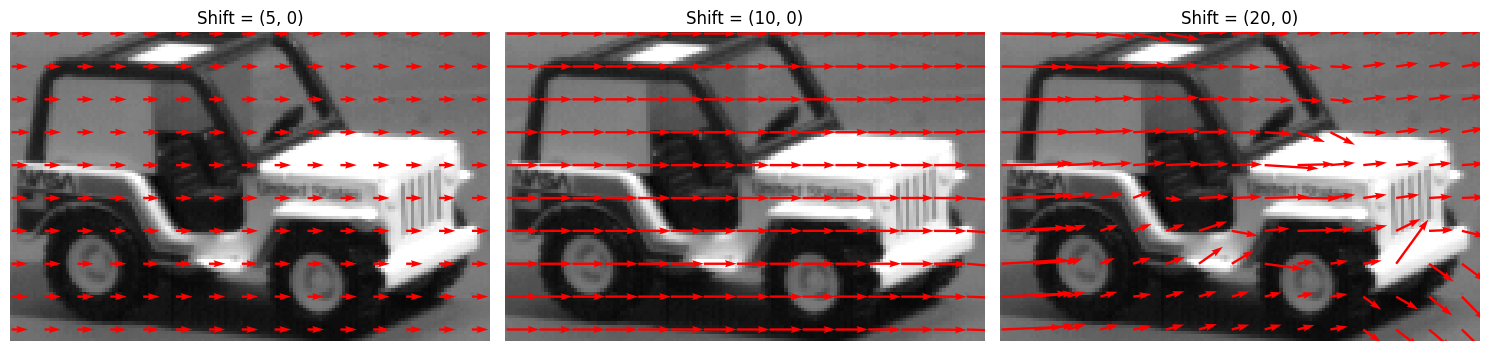

In [55]:
path = '/content/drive/My Drive/Images/auto1.tiff'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

shifts = [(5, 0), (10, 0), (20, 0)]
flows  = [optical_flow_shift(img, dx, dy) for dx, dy in shifts]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
step = 10  # plot every 10th vector

for ax, (dx, dy), flow in zip(axes, shifts, flows):
    v, u = flow
    H, W = img.shape
    Y, X = np.mgrid[0:H:step, 0:W:step]
    ax.imshow(img, cmap='gray')
    ax.quiver(X, Y, u[::step, ::step], v[::step, ::step],
              color='r', angles='xy', scale_units='xy', scale=1)
    ax.set_title(f'Shift = ({dx}, {dy})')
    ax.axis('off')

plt.tight_layout()
plt.show()

The optical‐flow vectors clearly capture the imposed horizontal translations: for a 5-pixel shift, the arrows point uniformly right with moderate length; at 10 pixels, they double in length while remaining consistent; and at 20 pixels the arrows are longest, faithfully reflecting the larger displacement. Only near the image borders do minor deviations appear (due to padding), but overall the TV-L1 flow solver accurately recovers the constant motion across the entire frame.